In [1]:
# All imports                                                                                       Purpose
import numpy as np #--------------------------------------------------------------------------------Numerical computations
import pandas as pd #-------------------------------------------------------------------------------Data structures
import matplotlib.pyplot as plt #-------------------------------------------------------------------Statistic visualizations
import seaborn as sns #-----------------------------------------------------------------------------"
import statsmodels.api as sm #----------------------------------------------------------------------Regression modeling
from sklearn.linear_model import LinearRegression, LogisticRegression #-----------------------------"
from sklearn.cluster import KMeans #----------------------------------------------------------------Clustering modeling
from sklearn.tree import DecisionTreeClassifier #---------------------------------------------------Decision Tree model
from sklearn.ensemble import RandomForestClassifier #-----------------------------------------------"
from xgboost import XGBClassifier #-----------------------------------------------------------------"
from scipy import stats #---------------------------------------------------------------------------Probability and stat tests
from sklearn.pipeline import Pipeline #-------------------------------------------------------------Pipeline preprocessing
from sklearn.compose import ColumnTransformer #-----------------------------------------------------"
from sklearn.impute import SimpleImputer #----------------------------------------------------------"
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures #-Data scalers
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV #---------------Model training & validation
from sklearn.metrics import root_mean_squared_error, r2_score, \
accuracy_score, confusion_matrix, classification_report #-------------------------------------------Model evaluation

In [2]:
# Import our data and view how it is structured

df = pd.read_csv('data/anon_cust_data.csv')
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        7043 non-null   int64  
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# Correct the TotalCharges column, eliminate the Unnamed: 0 column and check for missing values

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.drop('Unnamed: 0', axis=1)
print(df.nunique())
print(df.isnull().sum())

gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6530
Churn                  2
dtype: int64
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


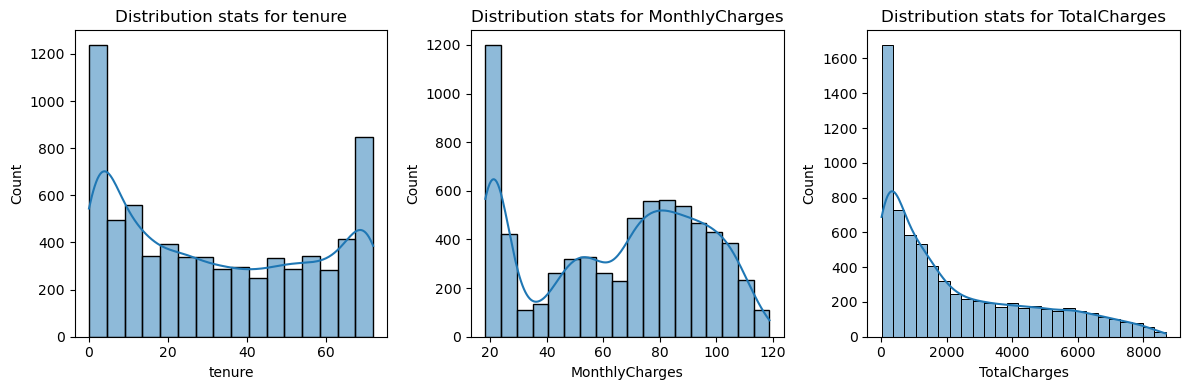

In [5]:
# Histograms of numerical columns (excluding SeniorCitizen since it is binary)

num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

plt.figure(figsize=(12, 4))
for i, col in enumerate(num_cols):
    plt.subplot(1, len(num_cols), i + 1)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution stats for {col}')
    plt.xlabel(col)
plt.tight_layout()
plt.show()

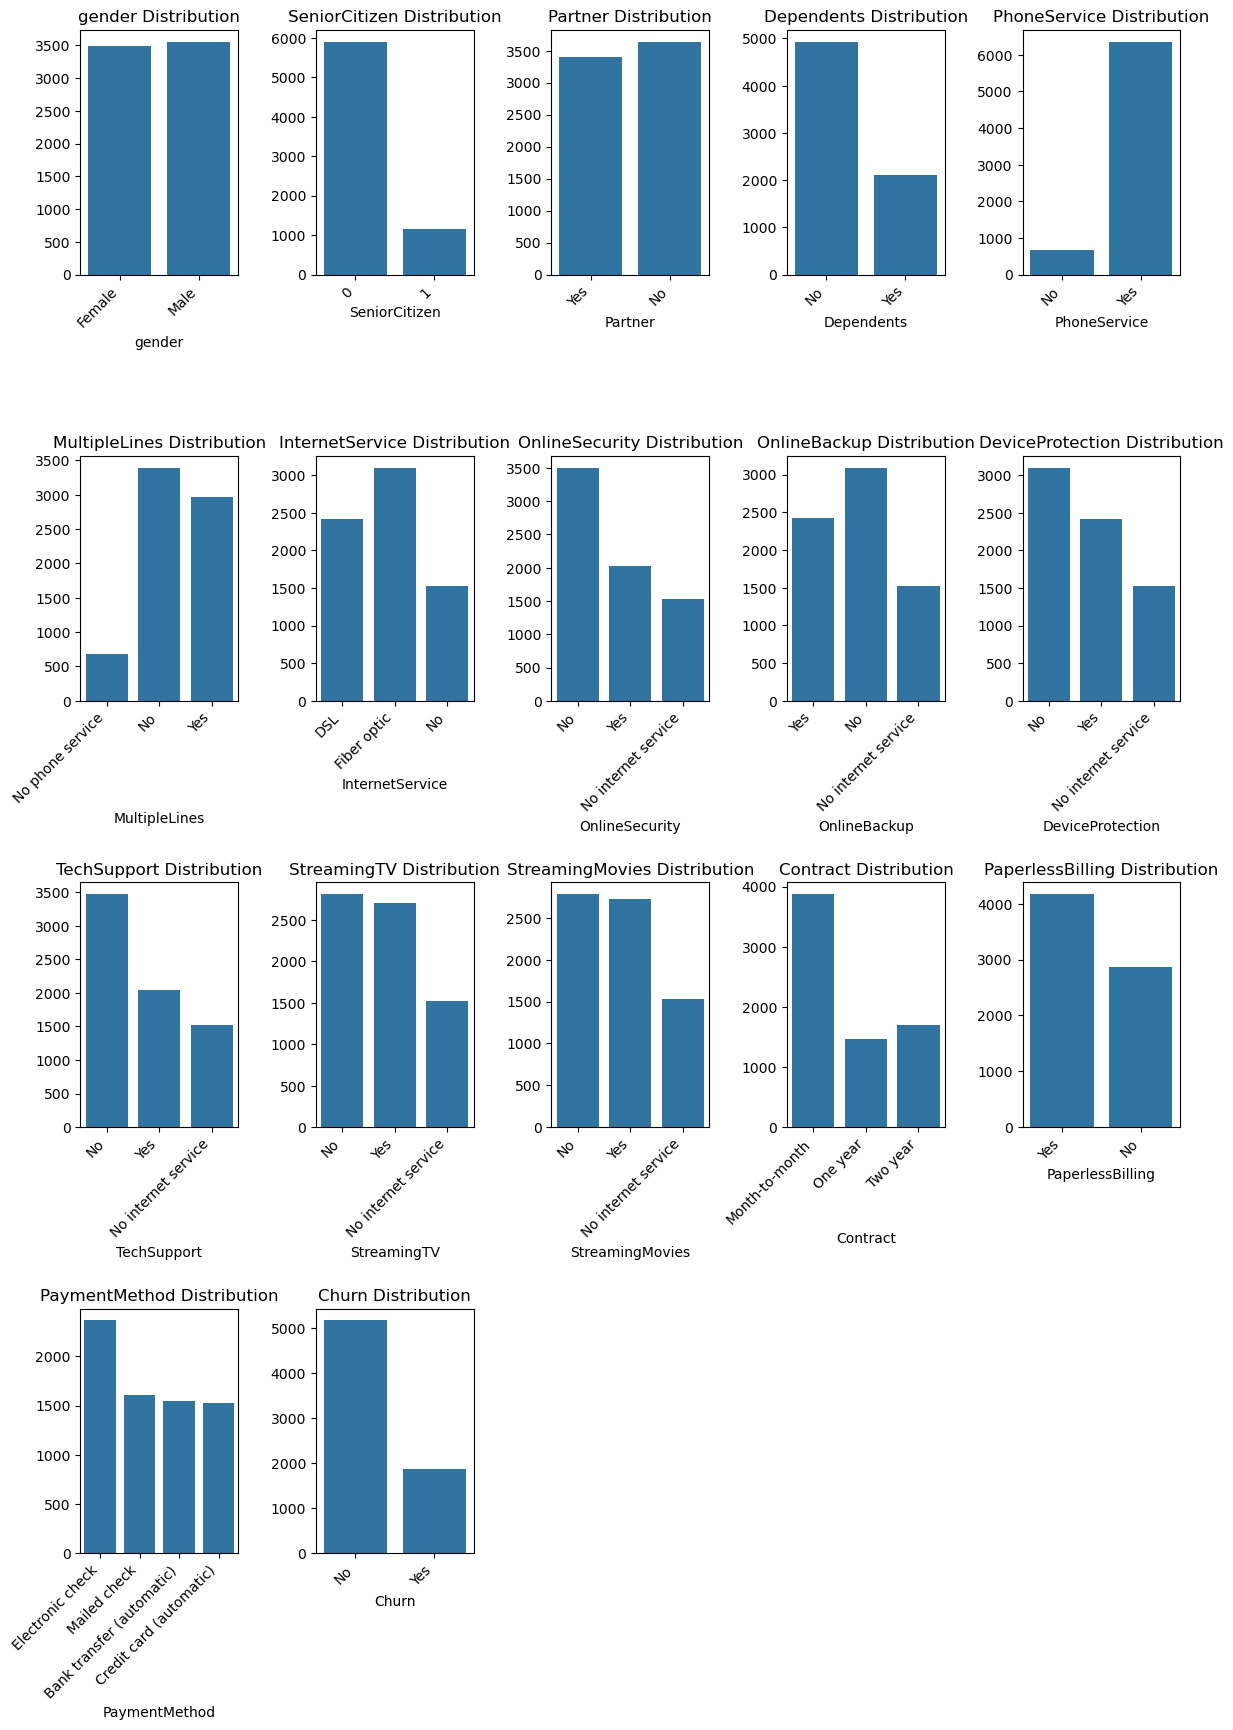

In [10]:
# View binary and categorical column data

cat_cols = df.drop(['tenure', 'MonthlyCharges', 'TotalCharges'], axis=1).columns

plt.figure(figsize=(12, 4 * ((len(cat_cols) + 3) // 4)))
for i, col in enumerate(cat_cols):
    plt.subplot((len(cat_cols) + 3) // 4, 5, i + 1) # Arrange in rows of 4 plots
    sns.countplot(data=df, x=col)
    plt.title(f'{col} Distribution')
    plt.xlabel(col)
    plt.ylabel('')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
###############################################################################
# 3. SPLIT DATA
# We do this before cleaning to avoid data leakage.
###############################################################################

X = df.drop(["Unnamed: 0", "Churn"], axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [ ]:
###############################################################################
# 5. PREPROCESS DATA
# We'll scale numeric features and one-hot encode categorical features.
# We'll also handle missing values using SimpleImputer.
###############################################################################

numeric_features = X.select_dtypes(include=['float', 'int']).columns
categorical_features = X.select_dtypes(include='object').columns

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),   # Fill missing with mean
    ("scaler", MinMaxScaler()),                    # Scale to [0, 1]
    ("poly", PolynomialFeatures(degree=3, include_bias=False))]) 

categorical_transformer = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)])

###############################################################################
# 6. TRAIN A MODEL
# We'll use a Random Forest. We'll do a quick training with a pipeline.
###############################################################################

model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))])

model.fit(X_train, y_train)

###############################################################################
# 7. EVALUATE THE MODEL
###############################################################################

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("\n--- INITIAL MODEL EVALUATION ---")
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

###############################################################################
# 8. TUNE HYPERPARAMETERS AND REEVALUATE
# We'll do a GridSearch for better Random Forest settings.
###############################################################################

param_grid = {
    "classifier__n_estimators": [50, 100],
    "classifier__max_depth": [None, 5, 10]}

grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\n--- BEST PARAMETERS AFTER GRID SEARCH ---")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

accuracy_best = accuracy_score(y_test, y_pred_best)
print("\n--- MODEL EVALUATION AFTER TUNING ---")
print("Accuracy:", accuracy_best)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))